In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Ensembling

In [3]:
ratio_list = np.logspace(-1,1,20)
tau = 0.1
D = 100
psi2 = 1.
K = 100
lam = 0.0001
K_list = [1,2,10]

mu0=1/np.sqrt(2*np.pi)
act = lambda x : F.relu(x) - mu0

dic = defaultdict(list)
dic['psi1/psi2']=np.log10(ratio_list)

for i, ratio in enumerate(ratio_list):
    print(i,end=' ')

    psi1=ratio*psi2
    P = int(D * psi1)
    N = int(D * psi2)


    X = torch.randn((N,D))
    teacher = torch.randn((D,))
    y = X @ teacher / D**0.5 + tau * torch.randn((N,))

    rf = torch.randn((K,D,P))
    a = torch.randn((K,P))

    for k in range(K):
        Z = act(X @ rf[k] / D**0.5) / D**0.5
        a[k] = y @ Z @ torch.pinverse(Z.t() @ Z + psi1 * psi2 * lam * torch.eye(P))
            
    ypred = torch.einsum('knp,kp->kn',(act(X @ rf / D**0.5) / D**0.5,a))
    error = (ypred-y).pow(2).mean()
    tr_error = (ypred-y).mean(0).pow(2).mean()
    dic['tr_error'].append(tr_error.item())
    
    def test(k):
        te_errors = []
        for ik in range(int(K/k)):
            X = torch.randn((N,D))
            y = X @ teacher / D**0.5 + tau * torch.randn((N,))
            ypred = torch.einsum('knp,kp->kn',(act(X @ rf[k*ik:k*(ik+1)] / D**0.5) / D**0.5, a[k*ik:k*(ik+1)]))
            te_error = (ypred-y).mean(0).pow(2).mean()
            te_errors.append(te_error.item())
        return np.mean(te_errors), np.std(te_errors)
            
    for k in K_list:
        mean, std = test(k)
        dic[k].append([mean,std])
    dic['norm'].append(a.norm(1).mean(0))
    dic['fluct'].append(a.std(1).mean(0))
        
df=pd.DataFrame.from_dict(dic)
df.to_csv('error.csv',index=False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

1
2
10


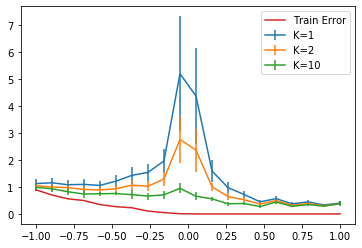

In [6]:
dic = pd.read_csv('error.csv')
for k in dic:
    try: print(int(k))
    except: continue
    vals = []
    errors = []
    for x in dic[k]:
        vals.append(eval(x)[0])
        errors.append(eval(x)[1])
    plt.errorbar(dic['psi1/psi2'], vals, errors, label='K=%d'%eval(k))

plt.plot(dic['psi1/psi2'], dic['tr_error'], label='Train Error')
plt.legend()